# Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import neccessary libraries

In [ ]:
!pip install nltk contractions
!pip install gradio
!pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gensim.downloader as api
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Load the Dataset

In [ ]:

# Load the CSV file
path = '/content/drive/MyDrive/AI_ML_Assignment2/train.csv'
df = pd.read_csv(path, header=None)

df.columns = ['Class Index', 'Title', 'Description']
df.head()


,Class Index,Title,Description
0,Class Index,Title,Description
1,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
2,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
3,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
4,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...


In [ ]:
# Combine title and description into one feature
df['Text'] = df['Title'] + ' ' + df['Description']

# Check updated dataframe
df[['Class Index', 'Text']].head()


,Class Index,Text
0,Class Index,Title Description
1,3,Wall St. Bears Claw Back Into the Black (Reute...
2,3,Carlyle Looks Toward Commercial Aerospace (Reu...
3,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
4,3,Iraq Halts Oil Exports from Main Southern Pipe...


# Cleaning

In [ ]:
df.sample(5)

,Class Index,Title,Description,Text
101663,2,Knicks #39; defense consistently bad,"The list of quot;bests, highests and biggests...",Knicks #39; defense consistently bad The list ...
14092,1,Muslims Appeal to Iraqi Captors,"BAGHDAD, 30 August 2004 - Muslim leaders in Ir...","Muslims Appeal to Iraqi Captors BAGHDAD, 30 Au..."
1613,3,Trial date set for ex-HealthSouth CEO Scrushy,"BIRMINGHAM, Ala. (AP) -- Fired HealthSouth chi...",Trial date set for ex-HealthSouth CEO Scrushy ...
97822,2,It #39;s been emotional says proud coach,GRAHAM HENRY admitted he was mentally shattere...,It #39;s been emotional says proud coach GRAHA...
33938,3,Update 3: Enron Jury Selection Begins in Houston,A judge overseeing the first criminal trial in...,Update 3: Enron Jury Selection Begins in Houst...


In [ ]:
df.shape

(120001, 4)

In [ ]:
df.size

480004

In [ ]:
df.columns

Index(['Class Index', 'Title', 'Description', 'Text'], dtype='object')

In [ ]:
df.dtypes

,0
Class Index,object
Title,object
Description,object
Text,object


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned)

df['cleaned_text'] = df['Text'].apply(clean_text)

In [ ]:
slang_dict = {
    'u': 'you',
    'r': 'are',
    'ur': 'your',
    'thx': 'thanks',
    'pls': 'please',
    'imo': 'in my opinion',
    'idk': 'i do not know',
    'btw': 'by the way'
}

def normalize_slang(text):
    for slang, replacement in slang_dict.items():
        text = re.sub(r'\b' + re.escape(slang) + r'\b', replacement, text)
    return text


In [ ]:
sample_text = "u r amazing btw"
normalized_text = normalize_slang(sample_text)
print(normalized_text)
df['text'] = df['Text'].apply(normalize_slang)

you are amazing by the way


In [ ]:
df['Clean_Text'] = df['Text'].apply(clean_text)
df[['Class Index', 'Clean_Text']].head()


,Class Index,Clean_Text
0,Class Index,title description
1,3,wall st bear claw back black reuters reuters s...
2,3,carlyle look toward commercial aerospace reute...
3,3,oil economy cloud stock outlook reuters reuter...
4,3,iraq halt oil export main southern pipeline re...


# Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

max_len = int(np.percentile([len(x) for x in sequences], 95))
X = pad_sequences(sequences, maxlen=max_len)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Class Index'])
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['Class Index']), y=df['Class Index'])
class_weight_dict = dict(enumerate(class_weights))


# Visualization

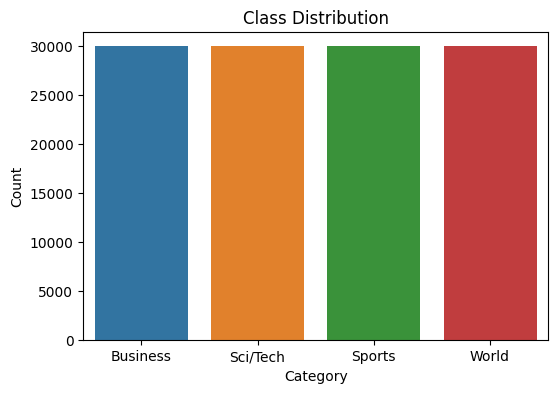

In [ ]:
class_labels = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
df['Label'] = df['Class Index'].map(class_labels)

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Label', hue='Label', legend=False)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

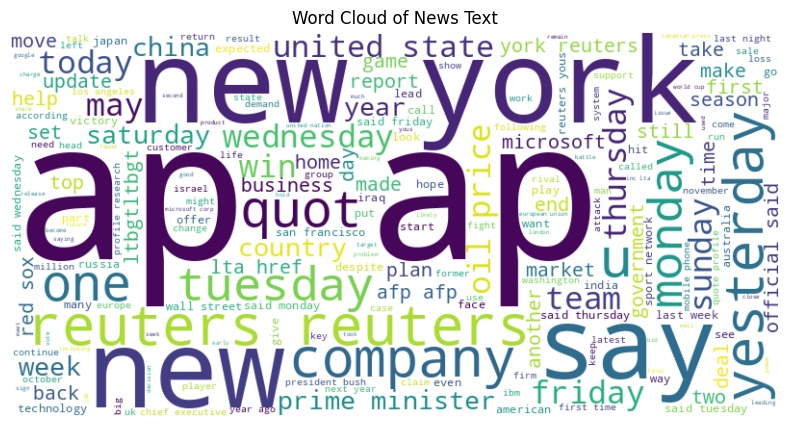

In [ ]:
df = pd.read_csv(path, header=0)

# Check the first few rows again
df.head()

# Combine title and description into one feature
df['Text'] = df['Title'] + ' ' + df['Description']

# Apply the clean_text function again to recreate the 'Clean_Text' column
df['Clean_Text'] = df['Text'].apply(clean_text)

# Now you can proceed with the rest of your code
text_all = ' '.join(df['Clean_Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Text')
plt.show()

<ipython-input-24-03df982ebe6d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='cool')


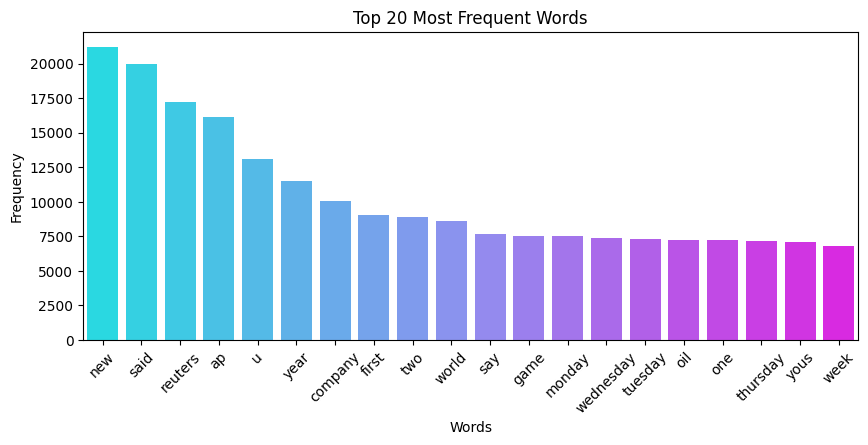

In [ ]:
all_words = ' '.join(df['Clean_Text']).split()
word_freq = Counter(all_words)

common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(10,4))
sns.barplot(x=list(words), y=list(counts), palette='cool')
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Simple RNN

In [ ]:
model_rnn = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_len),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(patience=2)

history_rnn = model_rnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),
                            class_weight=class_weight_dict, callbacks=[early_stop, lr_reduce])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - accuracy: 0.7567 - loss: 0.6199 - val_accuracy: 0.9005 - val_loss: 0.3184 - learning_rate: 0.0010
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - accuracy: 0.9130 - loss: 0.2860 - val_accuracy: 0.9000 - val_loss: 0.3356 - learning_rate: 0.0010
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 84s 19ms/step - accuracy: 0.9305 - loss: 0.2266 - val_accuracy: 0.9020 - val_loss: 0.3214 - learning_rate: 0.0010
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.9590 - loss: 0.1402 - val_accuracy: 0.9051 - val_loss: 0.3299 - learning_rate: 1.0000e-04


# LSTM

In [ ]:
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_len),
    LSTM(128),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),
                              class_weight=class_weight_dict, callbacks=[early_stop, lr_reduce])


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 204s 67ms/step - accuracy: 0.8196 - loss: 0.4786 - val_accuracy: 0.9114 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 195s 65ms/step - accuracy: 0.9287 - loss: 0.2224 - val_accuracy: 0.9100 - val_loss: 0.2641 - learning_rate: 0.0010
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 204s 66ms/step - accuracy: 0.9383 - loss: 0.1809 - val_accuracy: 0.9113 - val_loss: 0.2835 - learning_rate: 0.0010
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 200s 67ms/step - accuracy: 0.9506 - loss: 0.1455 - val_accuracy: 0.9068 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 193s 64ms/step - accuracy: 0.9659 - loss: 0.0991 - val_accuracy: 0.9082 - val_loss: 0.3279 - learning_rate: 1.0000e-04


# LSTM + Word2Vec

In [ ]:
word_vectors = api.load("word2vec-google-news-300")

embedding_matrix = np.zeros((10000, 300))
for word, i in tokenizer.word_index.items():
    if i >= 10000:
        continue
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

model_w2v = Sequential([
    Embedding(input_dim=10000, output_dim=300, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_w2v = model_w2v.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),
                            class_weight=class_weight_dict, callbacks=[early_stop, lr_reduce])


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 256s 84ms/step - accuracy: 0.8628 - loss: 0.4081 - val_accuracy: 0.8940 - val_loss: 0.3126 - learning_rate: 0.0010
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 233s 74ms/step - accuracy: 0.8973 - loss: 0.3023 - val_accuracy: 0.8937 - val_loss: 0.3079 - learning_rate: 0.0010
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 270s 77ms/step - accuracy: 0.9095 - loss: 0.2657 - val_accuracy: 0.9101 - val_loss: 0.2670 - learning_rate: 0.0010
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 255s 74ms/step - accuracy: 0.9172 - loss: 0.2372 - val_accuracy: 0.9137 - val_loss: 0.2551 - learning_rate: 0.0010
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 260s 74ms/step - accuracy: 0.9249 - loss: 0.2162 - val_accuracy: 0.9170 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 224s 75ms/step - accuracy: 0.9332 - loss: 0.1894 - val_accuracy: 0.9111 - val_loss: 0.2587 - learning_rate: 0.0010
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 262s 75ms/step -

# Confusion Matrix

750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Classification Report for Simple RNN:

              precision    recall  f1-score   support

           1       0.94      0.86      0.90      5956
           2       0.96      0.96      0.96      6058
           3       0.88      0.87      0.87      5911
           4       0.84      0.91      0.87      6075

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000



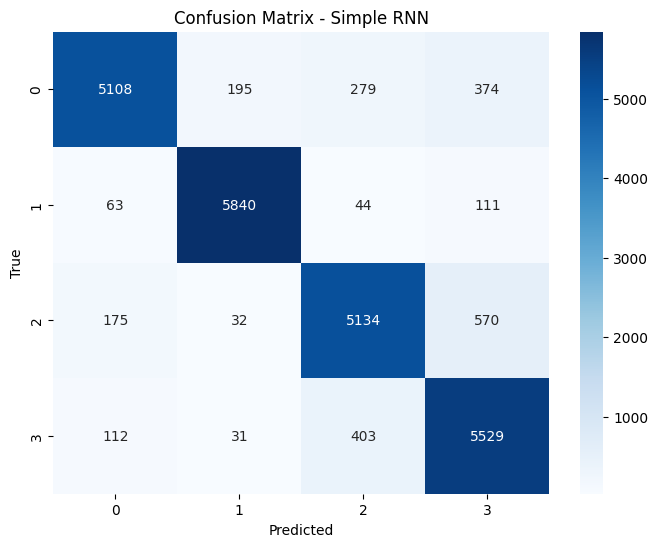


Sample predictions vs true labels:
True: 2, Predicted: 2
True: 2, Predicted: 2
True: 1, Predicted: 1
True: 3, Predicted: 3
True: 2, Predicted: 2
True: 1, Predicted: 1
True: 2, Predicted: 2
True: 0, Predicted: 3
True: 2, Predicted: 2
True: 3, Predicted: 3
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step

Classification Report for LSTM:

              precision    recall  f1-score   support

           1       0.94      0.88      0.91      5956
           2       0.95      0.98      0.96      6058
           3       0.90      0.86      0.87      5911
           4       0.86      0.92      0.89      6075

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000



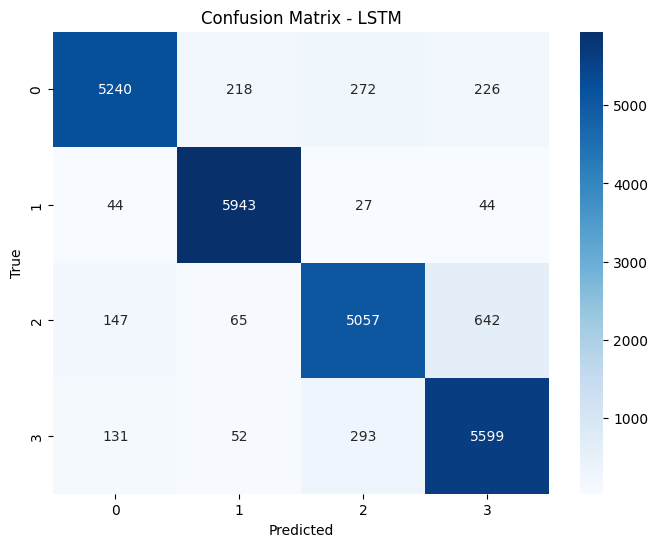


Sample predictions vs true labels:
True: 2, Predicted: 2
True: 2, Predicted: 2
True: 1, Predicted: 1
True: 3, Predicted: 3
True: 2, Predicted: 2
True: 1, Predicted: 1
True: 2, Predicted: 2
True: 0, Predicted: 2
True: 2, Predicted: 2
True: 3, Predicted: 3
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step

Classification Report for LSTM + Word2Vec:

              precision    recall  f1-score   support

           1       0.94      0.90      0.92      5956
           2       0.95      0.98      0.97      6058
           3       0.89      0.88      0.88      5911
           4       0.89      0.90      0.90      6075

    accuracy                           0.92     24000
   macro avg       0.92      0.92      0.92     24000
weighted avg       0.92      0.92      0.92     24000



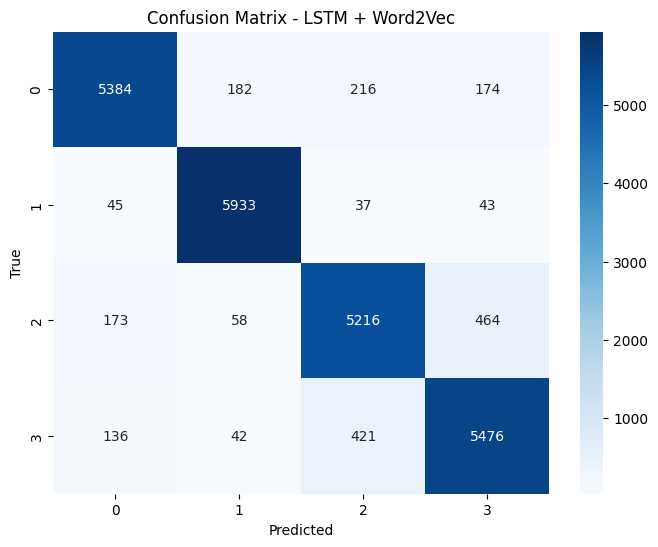


Sample predictions vs true labels:
True: 2, Predicted: 2
True: 2, Predicted: 2
True: 1, Predicted: 1
True: 3, Predicted: 3
True: 2, Predicted: 2
True: 1, Predicted: 1
True: 2, Predicted: 2
True: 0, Predicted: 2
True: 2, Predicted: 2
True: 3, Predicted: 3


In [ ]:
def evaluate_model(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"\nClassification Report for {label}:\n")
    print(classification_report(
        y_true,
        y_pred_classes,
        target_names=[str(cls) for cls in label_encoder.classes_]
    ))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Optional: Print some sample predictions
    print("\nSample predictions vs true labels:")
    for i in range(10):
        print(f"True: {y_true[i]}, Predicted: {y_pred_classes[i]}")
evaluate_model(model_rnn, X_test, y_test, "Simple RNN")
evaluate_model(model_lstm, X_test, y_test, "LSTM")
evaluate_model(model_w2v, X_test, y_test, "LSTM + Word2Vec")

In [ ]:
def get_model_metrics(model, X_test, y_test):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    return loss, acc

metrics = {
    'Simple RNN': get_model_metrics(model_rnn, X_test, y_test),
    'LSTM': get_model_metrics(model_lstm, X_test, y_test),
    'LSTM + Word2Vec': get_model_metrics(model_w2v, X_test, y_test)
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics, index=["Loss", "Accuracy"]).T.sort_values(by="Accuracy", ascending=False)
print(metrics_df)


                     Loss  Accuracy
LSTM + Word2Vec  0.245385  0.917042
LSTM             0.264085  0.909958
Simple RNN       0.318408  0.900458


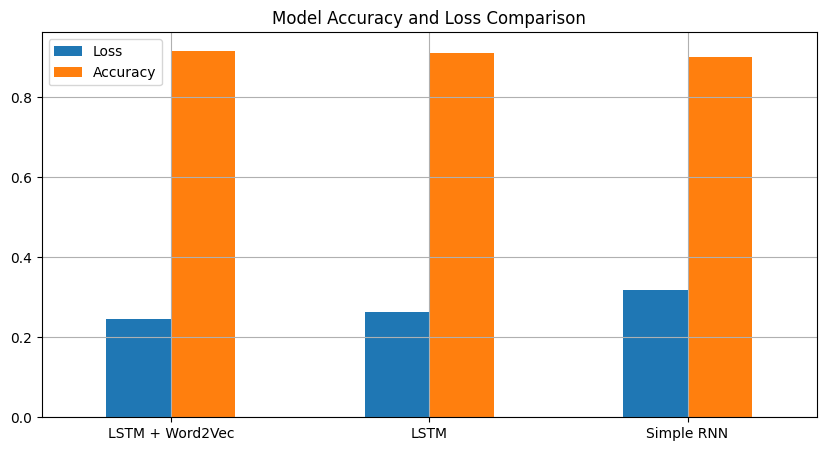

In [ ]:
metrics_df.plot(kind='bar', figsize=(10, 5), title='Model Accuracy and Loss Comparison')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


In [ ]:
def print_classification(model, name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))


In [ ]:
best_model = metrics_df['Accuracy'].idxmax()
best_accuracy = metrics_df['Accuracy'].max()
print(f"✅ The best performing model is: **{best_model}** with accuracy: **{best_accuracy:.2%}**")


✅ The best performing model is: **LSTM + Word2Vec** with accuracy: **91.70%**


In [ ]:
print("Simple RNN Summary:")
model_rnn.summary()

print("\nLSTM Summary:")
model_lstm.summary()

print("\nLSTM + Word2Vec Summary:")
model_w2v.summary()


Simple RNN Summary:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (32, 34, 64)           │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,945,550 (7.42 MB)

 Trainable params: 648,516 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,297,034 (4.95 MB)


LSTM Summary:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (32, 34, 64)           │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (32, 128)              │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,217,998 (8.46 MB)

 Trainable params: 739,332 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,478,666 (5.64 MB)


LSTM + Word2Vec Summary:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (32, 34, 300)          │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (32, 128)              │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,660,494 (13.96 MB)

 Trainable params: 220,164 (860.02 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

 Optimizer params: 440,330 (1.68 MB)

# GUI using Gradio

In [ ]:
import pandas as pd
import gradio as gr

def predict_topic_probs(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len)
    pred = model_w2v.predict(pad)[0]  # Get probabilities for all classes

    # Create a dataframe with class names and prediction probabilities
    class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

    result_df = pd.DataFrame({'Class': class_names, 'Probability': pred})
    result_df = result_df.sort_values(by='Probability', ascending=False).reset_index(drop=True)
    return result_df

interface = gr.Interface(
    fn=predict_topic_probs,
    inputs="text",
    outputs="dataframe",
    title="News Topic Classifier (All Predictions)"
)

interface.launch()



It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e265049a34ccd92bf4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
